In [19]:
import numpy as np
import xarray as xr
import os.path as op
from dask.diagnostics import ProgressBar
from scipy.interpolate import PchipInterpolator as pchip
from scipy.interpolate import interp2d
from matplotlib.gridspec import GridSpec as GS
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
sosedir = '/swot/SUM05/takaya/SOSE/mon_ave/bgc'
woadir = '/swot/SUM05/takaya/WOA'

In [3]:
# masks
woa_mask = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/'
                             '.Masks/.basin/dods/').rename({'X':'lon', 'Y':'lat', 'Z': 'depth'})
basin_names = woa_mask.basin.attrs['CLIST'].split('\n')
basins_main = { n: basin_names[n-1] for n in [1,2,3,10] }
basins_marginal = { n: basin_names[n-1] for n in [4,5,6,7,11] }

In [3]:
# url_base = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Grid-1x1/.Annual'
# url_nitr = url_base + '/.nitrate/.n_an/dods'
# url_phos = url_base + '/.phosphate/.p_an/dods '
# url_sili = url_base + '/.silicate/.i_an/dods'
# woa_nitr = xr.open_dataset(url_nitr)
# # woa_temp_nobs = xr.open_dataarray(url_base + '/.temperature/.t_dd/dods')
# woa_sili = xr.open_dataset(url_sili)
# woa_phos = xr.open_dataset(url_phos)
nitr_an = xr.open_dataset(op.join(woadir,'nitr/1deg/woa13_all_n00_01.nc'), decode_times=False)
phos_an = xr.open_dataset(op.join(woadir,'phos/1deg/woa13_all_p00_01.nc'), decode_times=False)
sili_an = xr.open_dataset(op.join(woadir,'sili/1deg/woa13_all_i00_01.nc'), decode_times=False)
# woa_clim = xr.merge([woa_phos, woa_nitr, woa_sili]).isel(time=0)
# woa_clim.load()
nitr_an

<xarray.Dataset>
Dimensions:             (depth: 102, lat: 180, lon: 360, nbounds: 2, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 ...
  * lon                 (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 ...
  * depth               (depth) float32 0.0 5.0 10.0 15.0 20.0 25.0 30.0 ...
  * time                (time) float32 6.0
Dimensions without coordinates: nbounds
Data variables:
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 ...
    lon_bnds            (lon, nbounds) float32 ...
    depth_bnds          (depth, nbounds) float32 ...
    climatology_bounds  (time, nbounds) float32 ...
    n_an                (time, depth, lat, lon) float32 ...
    n_mn                (time, depth, lat, lon) float32 ...
    n_dd                (time, depth, lat, lon) float64 ...
    n_sd                (time, depth, lat, lon) float32 ...
    n_se                (time, depth, lat, lon) float32 ...
    n_oa            

In [17]:
nitr_an.n_an.attrs

OrderedDict([('standard_name', 'moles_concentration_of_nitrate_in_sea_water'),
             ('long_name',
              'Objectively analyzed mean fields for moles_concentration_of_nitrate_in_sea_water at standard depth levels.'),
             ('cell_methods', 'area: mean depth: mean time: mean'),
             ('grid_mapping', 'crs'),
             ('units', 'micromoles_per_liter')])

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


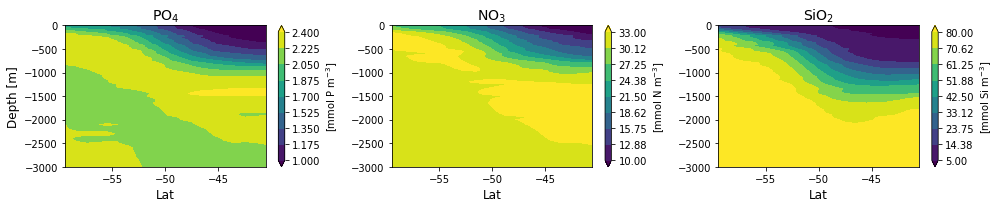

In [18]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14,3))
fig.set_tight_layout(True)
i1 = ax1.contourf(phos_an.lat.sel(lat=slice(-60,-40)), -phos_an.depth.sel(depth=slice(0,3e3)),
                 phos_an.p_an[0].sel(lat=slice(-60,-40),lon=slice(100,150),depth=slice(0.,3e3)).mean('lon'),
                 levels=np.linspace(1.,2.4,9), extend='both')
i2 = ax2.contourf(nitr_an.lat.sel(lat=slice(-60,-40)), -nitr_an.depth.sel(depth=slice(0,3e3)),
                 nitr_an.n_an[0].sel(lat=slice(-60,-40),lon=slice(100,150),depth=slice(0.,3e3)).mean('lon'),
                 levels=np.linspace(10,33,9), extend='both')
i3 = ax3.contourf(sili_an.lat.sel(lat=slice(-60,-40)), -sili_an.depth.sel(depth=slice(0,3e3)),
                 sili_an.i_an[0].sel(lat=slice(-60,-40),lon=slice(100,150),depth=slice(0.,3e3)).mean('lon'),
                 levels=np.linspace(5.,80.,9), extend='both')
ax1.set_ylim([-30e2,0])
ax2.set_ylim([-30e2,0])
ax3.set_ylim([-30e2,0])
ax1.set_ylabel('Depth [m]', fontsize=12)
ax1.set_xlabel('Lat', fontsize=12)
ax2.set_xlabel('Lat', fontsize=12)
ax3.set_xlabel('Lat', fontsize=12)
ax1.set_title(r"PO$_4$", fontsize=14)
ax2.set_title(r"NO$_3$", fontsize=14)
ax3.set_title(r"SiO$_2$", fontsize=14)
c1 = fig.colorbar(i1, ax=ax1)
c2 = fig.colorbar(i2, ax=ax2)
c3 = fig.colorbar(i3, ax=ax3)
c1.set_label(r"[mmol P m$^{-3}$]")
c2.set_label(r"[mmol N m$^{-3}$]")
c3.set_label(r"[mmol Si m$^{-3}$]")
plt.savefig(op.join(woadir, 'WOA_PNSi_40-60S_100-150E_top3000m.pdf'))

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


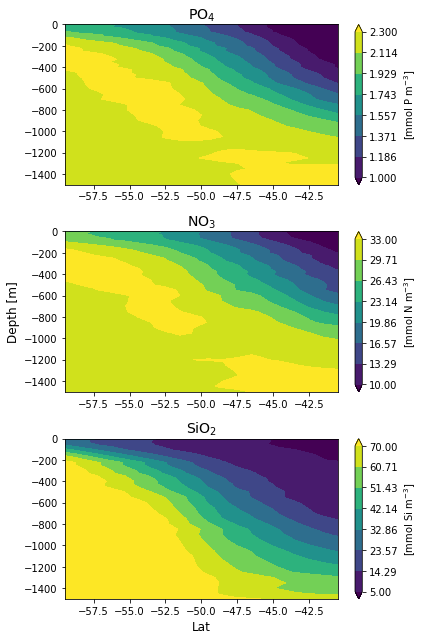

In [8]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(6,9))
fig.set_tight_layout(True)
i1 = ax1.contourf(phos_an.lat.sel(lat=slice(-60,-40)), -phos_an.depth.sel(depth=slice(0,3e3)),
                 phos_an.p_an[0].sel(lat=slice(-60,-40),lon=slice(50,150),depth=slice(0.,3e3)).mean('lon'),
                 levels=np.linspace(1.,2.3,8), extend='both'
                 )
i2 = ax2.contourf(nitr_an.lat.sel(lat=slice(-60,-40)), -nitr_an.depth.sel(depth=slice(0,3e3)),
                 nitr_an.n_an[0].sel(lat=slice(-60,-40),lon=slice(50,150),depth=slice(0.,3e3)).mean('lon'),
                 levels=np.linspace(10,33,8), extend='both'
                 )
i3 = ax3.contourf(sili_an.lat.sel(lat=slice(-60,-40)), -sili_an.depth.sel(depth=slice(0,3e3)),
                 sili_an.i_an[0].sel(lat=slice(-60,-40),lon=slice(50,150),depth=slice(0.,3e3)).mean('lon'),
                 levels=np.linspace(5.,70.,8), extend='both'
                 )
ax1.set_ylim([-15e2,0])
ax2.set_ylim([-15e2,0])
ax3.set_ylim([-15e2,0])
# ax1.set_ylabel('Depth [m]', fontsize=12)
ax2.set_ylabel('Depth [m]', fontsize=12)
# ax3.set_ylabel('Depth [m]', fontsize=12)
# ax1.set_xlabel('Lat', fontsize=12)
# ax2.set_xlabel('Lat', fontsize=12)
ax3.set_xlabel('Lat', fontsize=12)
ax1.set_title(r"PO$_4$", fontsize=14)
ax2.set_title(r"NO$_3$", fontsize=14)
ax3.set_title(r"SiO$_2$", fontsize=14)
c1 = fig.colorbar(i1, ax=ax1)
c2 = fig.colorbar(i2, ax=ax2)
c3 = fig.colorbar(i3, ax=ax3)
c1.set_label(r"[mmol P m$^{-3}$]")
c2.set_label(r"[mmol N m$^{-3}$]")
c3.set_label(r"[mmol Si m$^{-3}$]")
plt.savefig(op.join(woadir, 'WOA_PNSi_40-60S_50-150E_top1500m_3rows.pdf'))

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


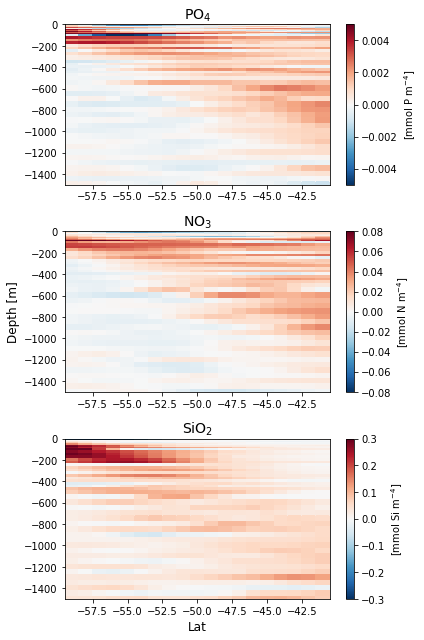

In [172]:
dPdz = (phos_an.p_an[0].sel(lat=slice(-60,-40),lon=slice(50,150)).mean('lon').diff('depth')
       / phos_an.depth.diff('depth'))
dNdz = (nitr_an.n_an[0].sel(lat=slice(-60,-40),lon=slice(50,150)).mean('lon').diff('depth')
       / nitr_an.depth.diff('depth'))
dIdz = (sili_an.i_an[0].sel(lat=slice(-60,-40),lon=slice(50,150)).mean('lon').diff('depth')
       / sili_an.depth.diff('depth'))
zmid = .5*(phos_an.depth[1:]+phos_an.depth[:-1].data)

fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(6,9))
fig.set_tight_layout(True)
i1 = ax1.pcolormesh(phos_an.lat.sel(lat=slice(-60,-40)), -zmid, dPdz,
                   rasterized=True, cmap='RdBu_r', vmax=5e-3, vmin=-5e-3)
i2 = ax2.pcolormesh(nitr_an.lat.sel(lat=slice(-60,-40)), -zmid, dNdz,
                   rasterized=True, cmap='RdBu_r', vmax=8e-2, vmin=-8e-2)
i3 = ax3.pcolormesh(sili_an.lat.sel(lat=slice(-60,-40)), -zmid, dIdz,
                   rasterized=True, cmap='RdBu_r', vmax=3e-1, vmin=-3e-1)
ax1.set_ylim([-15e2,0])
ax2.set_ylim([-15e2,0])
ax3.set_ylim([-15e2,0])
# ax1.set_ylabel('Depth [m]', fontsize=12)
ax2.set_ylabel('Depth [m]', fontsize=12)
# ax3.set_ylabel('Depth [m]', fontsize=12)
# ax1.set_xlabel('Lat', fontsize=12)
# ax2.set_xlabel('Lat', fontsize=12)
ax3.set_xlabel('Lat', fontsize=12)
ax1.set_title(r"PO$_4$", fontsize=14)
ax2.set_title(r"NO$_3$", fontsize=14)
ax3.set_title(r"SiO$_2$", fontsize=14)
c1 = fig.colorbar(i1, ax=ax1)
c2 = fig.colorbar(i2, ax=ax2)
c3 = fig.colorbar(i3, ax=ax3)
c1.set_label(r"[mmol P m$^{-4}$]")
c2.set_label(r"[mmol N m$^{-4}$]")
c3.set_label(r"[mmol Si m$^{-4}$]")
plt.savefig(op.join(woadir, 'WOA_dPNSidz_40-60S_50-150E_top1500m_3rows.pdf'))

In [33]:
woa_sili.i_an.sel(lat=slice(-65,-45),depth=slice(0,3e3)).mean('lon')

<xarray.DataArray 'i_an' (time: 1, depth: 77, lat: 20)>
array([[[ 49.196198,  45.758595, ...,   4.458974,   3.998861],
        [ 48.93555 ,  45.5984  , ...,   4.455986,   4.000164],
        ...,
        [125.376884, 125.97902 , ..., 104.56909 , 103.16403 ],
        [125.69712 , 126.37867 , ..., 106.66351 , 105.277405]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -64.5 -63.5 -62.5 -61.5 -60.5 -59.5 -58.5 -57.5 ...
  * depth    (depth) float32 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 45.0 ...
  * time     (time) float32 6.0

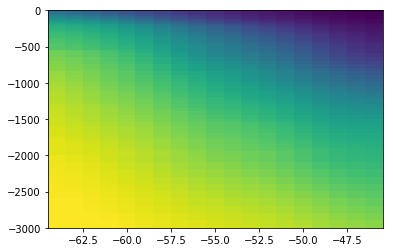

In [34]:
fig, ax = plt.subplots()
ax.pcolormesh(woa_sili.lat.sel(lat=slice(-65,-45)), -woa_sili.depth.sel(depth=slice(0,3e3)), 
              woa_sili.i_an.sel(lat=slice(-65,-45),depth=slice(0,3e3)).mean('lon')[0]
             )

In [21]:
Z = np.array([   -5. ,   -15. ,   -25. ,   -36. ,   -49. ,   -64. ,   -81.5,  -102. ,
        -126. ,  -154. ,  -187. ,  -226. ,  -272. ,  -327. ,  -393. ,  -471.5,
        -565. ,  -667.5,  -770.5,  -873.5,  -976.5, -1079.5, -1182.5, -1285.5,
       -1388.5, -1491.5, -1594.5, -1697.5, -1800.5, -1903.5, -2006.5, -2109.5,
       -2212.5, -2315.5, -2418.5, -2521.5, -2624.5, -2727.5, -2830.5, -2933.5])
# Z = np.array([-5.000000e-01, -1.570000e+00, -2.790000e+00, -4.185000e+00,
#            -5.780000e+00, -7.595000e+00, -9.660000e+00, -1.201000e+01,
#            -1.468000e+01, -1.770500e+01, -2.112500e+01, -2.499000e+01,
#            -2.934500e+01, -3.424000e+01, -3.972500e+01, -4.585500e+01,
#            -5.269000e+01, -6.028000e+01, -6.868500e+01, -7.796500e+01,
#            -8.817500e+01, -9.937000e+01, -1.116000e+02, -1.249150e+02,
#            -1.393650e+02, -1.549900e+02, -1.718250e+02, -1.899000e+02,
#            -2.092350e+02, -2.298550e+02, -2.517700e+02, -2.749850e+02,
#            -2.995050e+02, -3.253200e+02, -3.524200e+02, -3.807900e+02,
#            -4.104100e+02, -4.412550e+02, -4.733050e+02, -5.065400e+02,
#            -5.409350e+02, -5.764650e+02, -6.131100e+02, -6.508550e+02,
#            -6.896850e+02, -7.295950e+02, -7.705850e+02, -8.126600e+02,
#            -8.558350e+02, -9.001350e+02, -9.455950e+02, -9.922600e+02,
#            -1.040180e+03, -1.089425e+03, -1.140080e+03, -1.192235e+03,
#            -1.246005e+03, -1.301520e+03, -1.358920e+03, -1.418375e+03,
#            -1.480075e+03, -1.544225e+03, -1.611060e+03, -1.680845e+03,
#            -1.753875e+03, -1.830475e+03, -1.911015e+03, -1.995905e+03,
#            -2.085595e+03, -2.180595e+03, -2.281470e+03, -2.388845e+03,
#            -2.503415e+03, -2.625955e+03, -2.757325e+03, -2.912665e+03])

In [22]:
func = pchip(woa_clim.depth, woa_phos.p_an.sel(lat=-45.,method='nearest').sel(lon=slice(50,150)).mean(['lon'])[0], axis=0)
phos_clim = func(np.abs(Z))
func = pchip(woa_clim.depth, woa_nitr.n_an.sel(lat=-45.,method='nearest').sel(lon=slice(50,150)).mean(['lon'])[0], axis=0)
nitr_clim = func(np.abs(Z))
func = pchip(woa_clim.depth, woa_sili.i_an.sel(lat=-45.,method='nearest').sel(lon=slice(50,150)).mean(['lon'])[0], axis=0)
sili_clim = func(np.abs(Z))

NameError: name 'woa_clim' is not defined

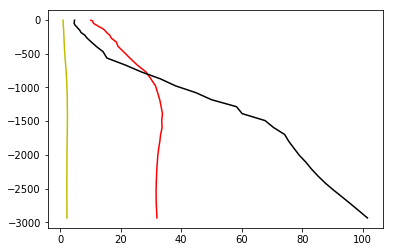

In [38]:
fig, ax = plt.subplots()
ax.plot(phos_clim,Z,'y')
ax.plot(nitr_clim,Z,'r')
ax.plot(sili_clim,Z,'k')

In [23]:
# url_base = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Grid-1x1/.Monthly'
# url_nitr = url_base + '/.nitrate/.n_mn/dods'
# url_phos = url_base + '/.phosphate/.p_mn/dods '
# url_sili = url_base + '/.silicate/.i_mn/dods'
# woa_nitr = xr.open_dataset(url_nitr, decode_times=False)
# # woa_temp_nobs = xr.open_dataarray(url_base + '/.temperature/.t_dd/dods')
# woa_sili = xr.open_dataset(url_sili, decode_times=False)
# woa_phos = xr.open_dataset(url_phos, decode_times=False)
# woa_mon = xr.merge([woa_phos, woa_nitr, woa_sili, woa_mask])
# woa_mon.load()
nitr_mn = xr.open_mfdataset(op.join(woadir,'nitr/1deg/monthly/*.nc'), decode_times=False)
phos_mn = xr.open_mfdataset(op.join(woadir,'phos/1deg/monthly/*.nc'), decode_times=False)
sili_mn = xr.open_mfdataset(op.join(woadir,'sili/1deg/monthly/*.nc'), decode_times=False)
sili_mn

<xarray.Dataset>
Dimensions:             (depth: 37, lat: 180, lon: 360, nbounds: 2, time: 12)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 ...
  * lon                 (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 ...
  * depth               (depth) float32 0.0 5.0 10.0 15.0 20.0 25.0 30.0 ...
  * time                (time) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 ...
Dimensions without coordinates: nbounds
Data variables:
    crs                 (time) int32 -2147483647 -2147483647 -2147483647 ...
    lat_bnds            (time, lat, nbounds) float32 dask.array<shape=(12, 180, 2), chunksize=(1, 180, 2)>
    lon_bnds            (time, lon, nbounds) float32 dask.array<shape=(12, 360, 2), chunksize=(1, 360, 2)>
    depth_bnds          (time, depth, nbounds) float32 dask.array<shape=(12, 37, 2), chunksize=(1, 37, 2)>
    climatology_bounds  (time, nbounds) float32 dask.array<shape=(12, 2), chunksize=(1, 2)>
    i_an                (time, dept

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


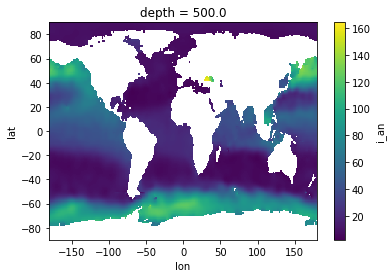

In [49]:
sili_mn.i_an.mean('time')[-1].plot()

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


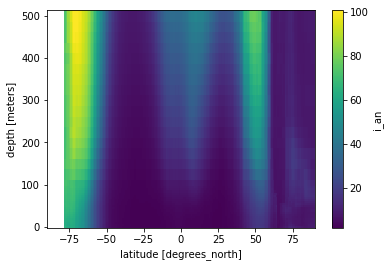

In [30]:
sili_mn.i_an.mean(['time','lon']).plot()

In [24]:
phos_mon = xr.DataArray(np.zeros((12,102,180,360)),dims=['time','depth','lat','lon'],
                        coords={'time':phos_mn.time.data,'depth':phos_an.depth.data,
                               'lat':phos_mn.lat.data,'lon':phos_mn.lon.data})
nitr_mon = xr.DataArray(np.zeros((12,102,180,360)),dims=['time','depth','lat','lon'],
                        coords={'time':nitr_mn.time.data,'depth':nitr_an.depth.data,
                               'lat':nitr_mn.lat.data,'lon':nitr_mn.lon.data})
sili_mon = xr.DataArray(np.zeros((12,102,180,360)),dims=['time','depth','lat','lon'],
                        coords={'time':sili_mn.time.data,'depth':sili_an.depth.data,
                               'lat':sili_mn.lat.data,'lon':sili_mn.lon.data})
phos_mon[:,:37] = phos_mn.p_an
phos_mon[:,37:] = phos_an.p_an[0,37:]
nitr_mon[:,:37] = nitr_mn.n_an
nitr_mon[:,37:] = nitr_an.n_an[0,37:]
sili_mon[:,:37] = sili_mn.i_an
sili_mon[:,37:] = sili_an.i_an[0,37:]

In [89]:
sili_mon

<xarray.DataArray (time: 12, depth: 102, lat: 180, lon: 360)>
array([[[[      nan, ...,       nan],
         ...,
         [13.851043, ..., 13.851043]],

        ...,

        [[      nan, ...,       nan],
         ...,
         [      nan, ...,       nan]]],


       ...,


       [[[      nan, ...,       nan],
         ...,
         [ 5.776092, ...,  5.776092]],

        ...,

        [[      nan, ...,       nan],
         ...,
         [      nan, ...,       nan]]]])
Coordinates:
  * time     (time) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * depth    (depth) float32 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 45.0 ...
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...

In [13]:
ds.Fe.attrs

OrderedDict([('dimension', 'mol Fe/m3')])

In [17]:
sili_an.i_an.attrs

OrderedDict([('standard_name', 'moles_concentration_of_silicate_in_sea_water'),
             ('long_name',
              'Objectively analyzed mean fields for moles_concentration_of_silicate_in_sea_water at standard depth levels.'),
             ('cell_methods', 'area: mean depth: mean time: mean'),
             ('grid_mapping', 'crs'),
             ('units', 'micromoles_per_liter')])

In [25]:
Si = sili_mon.sel(lat=slice(-65.,-40.),lon=slice(50,150)).mean('lon').sel(depth=slice(0,5e2))
NO3 = nitr_mon.sel(lat=slice(-65.,-40.),lon=slice(50,150)).mean('lon').sel(depth=slice(0,5e2))
PO4 = phos_mon.sel(lat=slice(-65.,-40.),lon=slice(50,150)).mean('lon').sel(depth=slice(0,5e2))
ds = xr.open_dataset(op.join(sosedir, 'bsose_i105_2008to2012_monthly_Fe.nc'))
Fe = xr.DataArray(ds.Fe.data*1e3, dims=['iTIME','z','lat','lon'],
                 coords={'iTIME':range(60),'z':-ds.depth.data,'lat':ds.lat.data,'lon':ds.lon.data,
                        'month':('iTIME',np.tile(range(12),5))}
                 ).sel(lat=slice(-65,-40),lon=slice(50,150),z=slice(0,-5e2)).groupby('month').mean(['iTIME','lon'])
Fe

<xarray.DataArray (month: 12, z: 30, lat: 128)>
array([[[0.000141, 0.00014 , ..., 0.000107, 0.000107],
        [0.000141, 0.00014 , ..., 0.000107, 0.000106],
        ...,
        [0.000458, 0.000458, ..., 0.000248, 0.000248],
        [0.000448, 0.000446, ..., 0.000261, 0.000261]],

       [[0.000128, 0.000127, ..., 0.000104, 0.000104],
        [0.000128, 0.000127, ..., 0.000104, 0.000104],
        ...,
        [0.00046 , 0.00046 , ..., 0.000248, 0.000248],
        [0.00045 , 0.000447, ..., 0.000261, 0.00026 ]],

       ...,

       [[0.000309, 0.000309, ..., 0.000135, 0.000133],
        [0.000309, 0.000309, ..., 0.000134, 0.000133],
        ...,
        [0.000445, 0.000446, ..., 0.000243, 0.000242],
        [0.000437, 0.000437, ..., 0.000256, 0.000255]],

       [[0.000217, 0.000215, ..., 0.000115, 0.000114],
        [0.000217, 0.000215, ..., 0.000115, 0.000114],
        ...,
        [0.000446, 0.000447, ..., 0.000242, 0.000242],
        [0.000438, 0.000438, ..., 0.000255, 0.000255]]])

In [65]:
kP1 = 0.035
kP2 = 0.015
r_FeP = 1.e-3
# r_FePs = .4e-3
r_NP = 16
r_SiP = 16
kSi1 = kP1 * r_SiP
kFe1 = kP1 * r_FeP
kN1 = kP1 * r_NP
# kFes = Kn1 * r_FePs
kFe2 = kP2 * r_FeP
kN2 = kP2 * r_NP
ny, nz = (26,10)
gammaSi1 = np.zeros((12,nz,ny))
gammaFe1 = np.zeros((12,nz,ny))
gammaN1 = np.zeros((12,nz,ny))
gammaP1 = np.zeros((12,nz,ny))
gammaFe2 = np.zeros((12,nz,ny))
gammaN2 = np.zeros((12,nz,ny))
gammaP2 = np.zeros((12,nz,ny))
for i in range(12):
    tmp = Si[i]/(Si[i]+kSi1)
    func = interp2d(Si.lat.data, np.abs(Si.depth.data), tmp.data)
    gammaSi1[i] = func(np.linspace(-65,-40,ny), np.linspace(0,5e2,nz))
    tmp = Fe[i]/(Fe[i]+kFe1)
    func = interp2d(Fe.lat.data, np.abs(Fe.z.data), tmp.data)
    gammaFe1[i] = func(np.linspace(-65,-40,ny), np.linspace(0,5e2,nz))
    tmp = PO4[i]/(PO4[i]+kP1)
    func = interp2d(PO4.lat.data, np.abs(PO4.depth.data), tmp.data)
    gammaP1[i] = func(np.linspace(-65,-40,ny), np.linspace(0,5e2,nz))
    tmp = NO3[i]/(NO3[i]+kN1)
    func = interp2d(NO3.lat.data, np.abs(NO3.depth.data), tmp.data)
    gammaN1[i] = func(np.linspace(-65,-40,ny), np.linspace(0,5e2,nz))
    
    tmp = Fe[i]/(Fe[i]+kFe2)
    func = interp2d(Fe.lat.data, np.abs(Fe.z.data), tmp.data)
    gammaFe2[i] = func(np.linspace(-65,-40,ny), np.linspace(0,5e2,nz))
    tmp = PO4[i]/(PO4[i]+kP2)
    func = interp2d(PO4.lat.data, np.abs(PO4.depth.data), tmp.data)
    gammaP2[i] = func(np.linspace(-65,-40,ny), np.linspace(0,5e2,nz))
    tmp = NO3[i]/(NO3[i]+kN2)
    func = interp2d(NO3.lat.data, np.abs(NO3.depth.data), tmp.data)
    gammaN2[i] = func(np.linspace(-65,-40,ny), np.linspace(0,5e2,nz))
# gammaFes = Fe/(Fe+kFes)
# func = interp2d(gammaFes.lat.data, np.abs(gammaFes.z.data), gammaFes.data)
# gammaFes = func(np.arange(-65,-40,1.), np.linspace(0,5e2,10))
# gammaFes

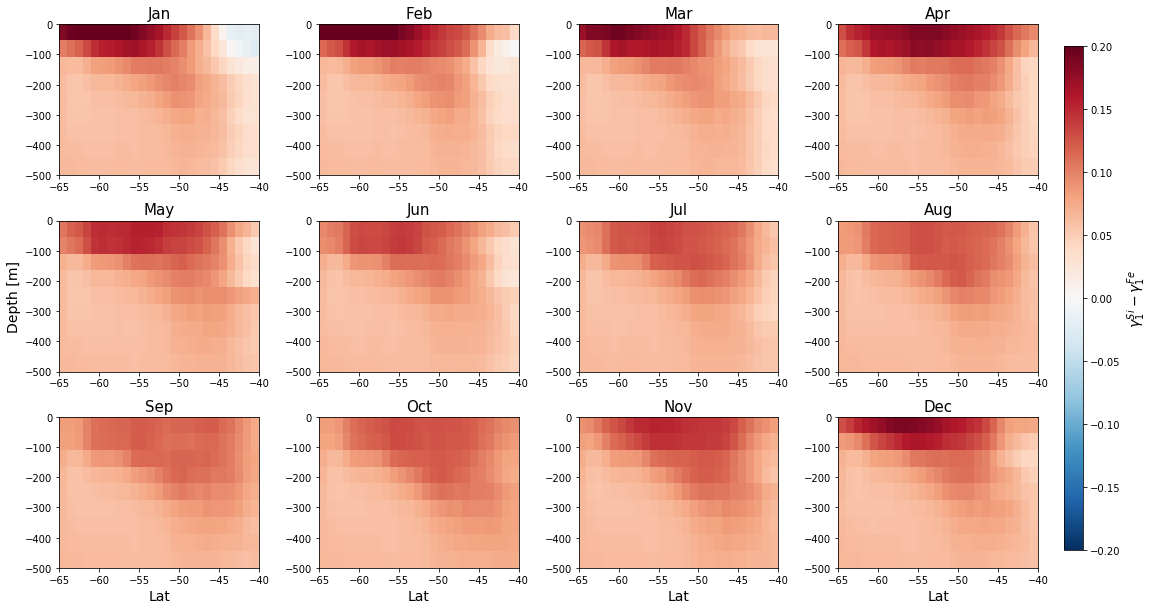

In [83]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18,10))
fig.subplots_adjust(right=0.88, hspace = 0.3, wspace = 0.3)
# fig.set_tight_layout(True)
im = axes[0,0].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaSi1-gammaFe1)[0],
                         vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[0,1].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaSi1-gammaFe1)[1],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[0,2].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaSi1-gammaFe1)[2],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[0,3].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaSi1-gammaFe1)[3],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)

axes[1,0].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaSi1-gammaFe1)[4],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[1,1].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaSi1-gammaFe1)[5],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[1,2].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaSi1-gammaFe1)[6],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[1,3].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaSi1-gammaFe1)[7],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)

axes[2,0].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaSi1-gammaFe1)[8],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[2,1].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaSi1-gammaFe1)[9],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[2,2].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaSi1-gammaFe1)[10],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[2,3].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaSi1-gammaFe1)[11],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
# cbar2 = fig.colorbar(im2, ax=ax2)
# fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"$\gamma^{Si}_1-\gamma^{Fe}_1$", fontsize=14)
axes[0,0].set_title(r"Jan", fontsize=15)
axes[0,1].set_title(r"Feb", fontsize=15)
axes[0,2].set_title(r"Mar", fontsize=15)
axes[0,3].set_title(r"Apr", fontsize=15)
axes[1,0].set_title(r"May", fontsize=15)
axes[1,1].set_title(r"Jun", fontsize=15)
axes[1,2].set_title(r"Jul", fontsize=15)
axes[1,3].set_title(r"Aug", fontsize=15)
axes[2,0].set_title(r"Sep", fontsize=15)
axes[2,1].set_title(r"Oct", fontsize=15)
axes[2,2].set_title(r"Nov", fontsize=15)
axes[2,3].set_title(r"Dec", fontsize=15)
axes[1,0].set_ylabel(r"Depth [m]", fontsize=14)
axes[2,0].set_xlabel(r"Lat", fontsize=14)
axes[2,1].set_xlabel(r"Lat", fontsize=14)
axes[2,2].set_xlabel(r"Lat", fontsize=14)
axes[2,3].set_xlabel(r"Lat", fontsize=14)
plt.savefig(op.join(woadir, 'ratio-of-gamma1SiandFe_WOA-SOSE.pdf'))

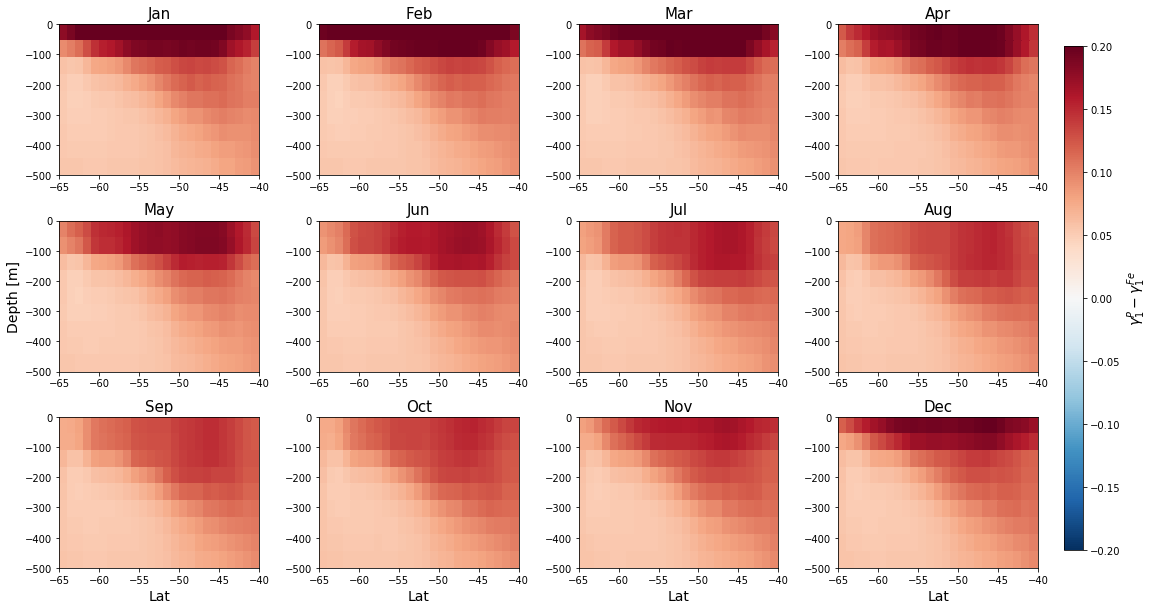

In [82]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18,10))
fig.subplots_adjust(right=0.88, hspace = 0.3, wspace = 0.3)
# fig.set_tight_layout(True)
im = axes[0,0].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP1-gammaFe1)[0],
                         vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[0,1].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP1-gammaFe1)[1],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[0,2].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP1-gammaFe1)[2],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[0,3].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP1-gammaFe1)[3],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)

axes[1,0].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP1-gammaFe1)[4],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[1,1].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP1-gammaFe1)[5],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[1,2].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP1-gammaFe1)[6],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[1,3].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP1-gammaFe1)[7],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)

axes[2,0].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP1-gammaFe1)[8],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[2,1].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP1-gammaFe1)[9],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[2,2].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP1-gammaFe1)[10],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[2,3].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP1-gammaFe1)[11],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
# cbar2 = fig.colorbar(im2, ax=ax2)
# fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"$\gamma^{P}_1-\gamma^{Fe}_1$", fontsize=14)
axes[0,0].set_title(r"Jan", fontsize=15)
axes[0,1].set_title(r"Feb", fontsize=15)
axes[0,2].set_title(r"Mar", fontsize=15)
axes[0,3].set_title(r"Apr", fontsize=15)
axes[1,0].set_title(r"May", fontsize=15)
axes[1,1].set_title(r"Jun", fontsize=15)
axes[1,2].set_title(r"Jul", fontsize=15)
axes[1,3].set_title(r"Aug", fontsize=15)
axes[2,0].set_title(r"Sep", fontsize=15)
axes[2,1].set_title(r"Oct", fontsize=15)
axes[2,2].set_title(r"Nov", fontsize=15)
axes[2,3].set_title(r"Dec", fontsize=15)
axes[1,0].set_ylabel(r"Depth [m]", fontsize=14)
axes[2,0].set_xlabel(r"Lat", fontsize=14)
axes[2,1].set_xlabel(r"Lat", fontsize=14)
axes[2,2].set_xlabel(r"Lat", fontsize=14)
axes[2,3].set_xlabel(r"Lat", fontsize=14)
plt.savefig(op.join(woadir, 'ratio-of-gamma1PandFe_WOA-SOSE.pdf'))

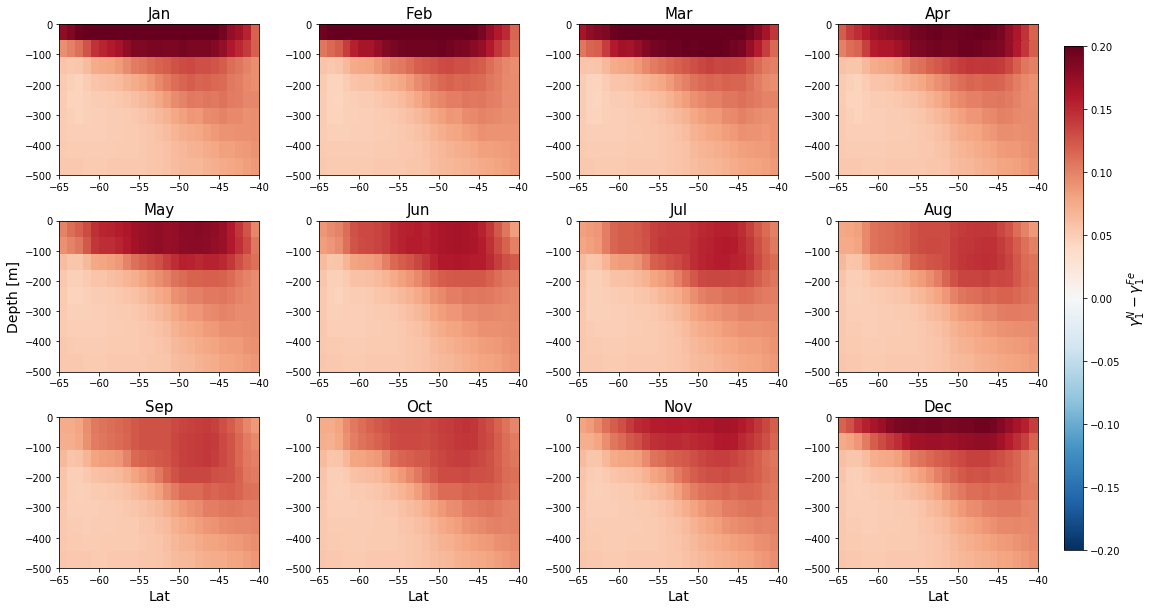

In [81]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18,10))
fig.subplots_adjust(right=0.88, hspace = 0.3, wspace = 0.3)
# fig.set_tight_layout(True)
im = axes[0,0].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN1-gammaFe1)[0],
                         vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[0,1].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN1-gammaFe1)[1],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[0,2].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN1-gammaFe1)[2],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[0,3].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN1-gammaFe1)[3],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)

axes[1,0].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN1-gammaFe1)[4],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[1,1].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN1-gammaFe1)[5],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[1,2].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN1-gammaFe1)[6],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[1,3].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN1-gammaFe1)[7],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)

axes[2,0].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN1-gammaFe1)[8],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[2,1].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN1-gammaFe1)[9],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[2,2].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN1-gammaFe1)[10],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[2,3].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN1-gammaFe1)[11],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
# cbar2 = fig.colorbar(im2, ax=ax2)
# fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"$\gamma^{N}_1-\gamma^{Fe}_1$", fontsize=14)
axes[0,0].set_title(r"Jan", fontsize=15)
axes[0,1].set_title(r"Feb", fontsize=15)
axes[0,2].set_title(r"Mar", fontsize=15)
axes[0,3].set_title(r"Apr", fontsize=15)
axes[1,0].set_title(r"May", fontsize=15)
axes[1,1].set_title(r"Jun", fontsize=15)
axes[1,2].set_title(r"Jul", fontsize=15)
axes[1,3].set_title(r"Aug", fontsize=15)
axes[2,0].set_title(r"Sep", fontsize=15)
axes[2,1].set_title(r"Oct", fontsize=15)
axes[2,2].set_title(r"Nov", fontsize=15)
axes[2,3].set_title(r"Dec", fontsize=15)
axes[1,0].set_ylabel(r"Depth [m]", fontsize=14)
axes[2,0].set_xlabel(r"Lat", fontsize=14)
axes[2,1].set_xlabel(r"Lat", fontsize=14)
axes[2,2].set_xlabel(r"Lat", fontsize=14)
axes[2,3].set_xlabel(r"Lat", fontsize=14)
plt.savefig(op.join(woadir, 'ratio-of-gamma1NandFe_WOA-SOSE.pdf'))

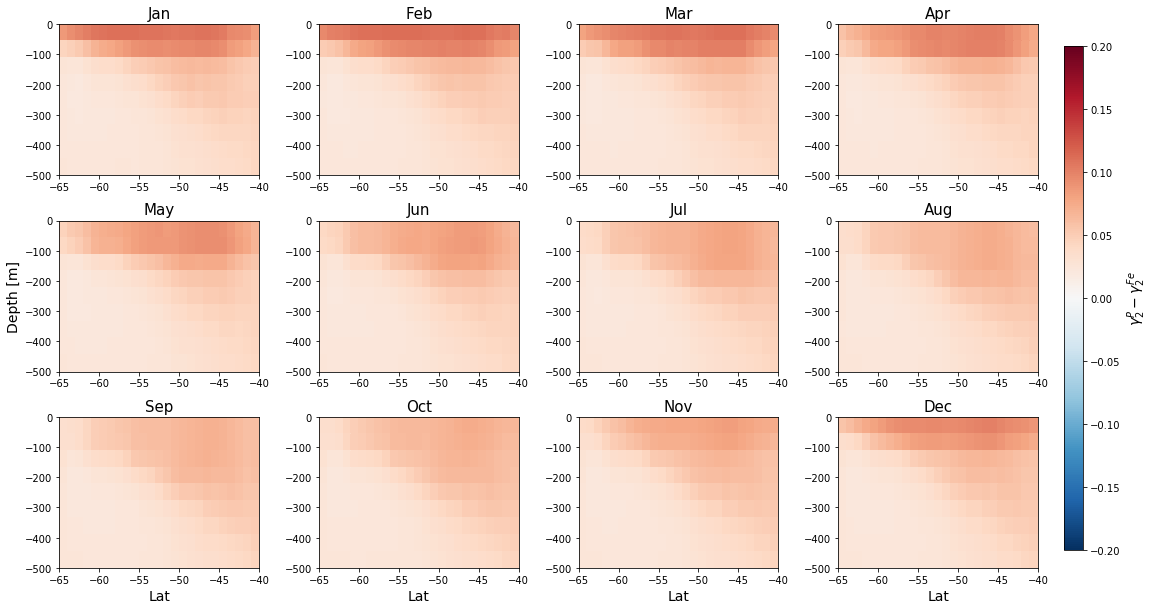

In [80]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18,10))
fig.subplots_adjust(right=0.88, hspace = 0.3, wspace = 0.3)
# fig.set_tight_layout(True)
im = axes[0,0].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP2-gammaFe2)[0],
                         vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[0,1].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP2-gammaFe2)[1],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[0,2].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP2-gammaFe2)[2],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[0,3].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP2-gammaFe2)[3],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)

axes[1,0].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP2-gammaFe2)[4],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[1,1].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP2-gammaFe2)[5],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[1,2].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP2-gammaFe2)[6],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[1,3].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP2-gammaFe2)[7],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)

axes[2,0].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP2-gammaFe2)[8],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[2,1].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP2-gammaFe2)[9],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[2,2].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP2-gammaFe2)[10],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[2,3].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaP2-gammaFe2)[11],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
# cbar2 = fig.colorbar(im2, ax=ax2)
# fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"$\gamma^{P}_2-\gamma^{Fe}_2$", fontsize=14)
axes[0,0].set_title(r"Jan", fontsize=15)
axes[0,1].set_title(r"Feb", fontsize=15)
axes[0,2].set_title(r"Mar", fontsize=15)
axes[0,3].set_title(r"Apr", fontsize=15)
axes[1,0].set_title(r"May", fontsize=15)
axes[1,1].set_title(r"Jun", fontsize=15)
axes[1,2].set_title(r"Jul", fontsize=15)
axes[1,3].set_title(r"Aug", fontsize=15)
axes[2,0].set_title(r"Sep", fontsize=15)
axes[2,1].set_title(r"Oct", fontsize=15)
axes[2,2].set_title(r"Nov", fontsize=15)
axes[2,3].set_title(r"Dec", fontsize=15)
axes[1,0].set_ylabel(r"Depth [m]", fontsize=14)
axes[2,0].set_xlabel(r"Lat", fontsize=14)
axes[2,1].set_xlabel(r"Lat", fontsize=14)
axes[2,2].set_xlabel(r"Lat", fontsize=14)
axes[2,3].set_xlabel(r"Lat", fontsize=14)
plt.savefig(op.join(woadir, 'ratio-of-gamma2PandFe_WOA-SOSE.pdf'))

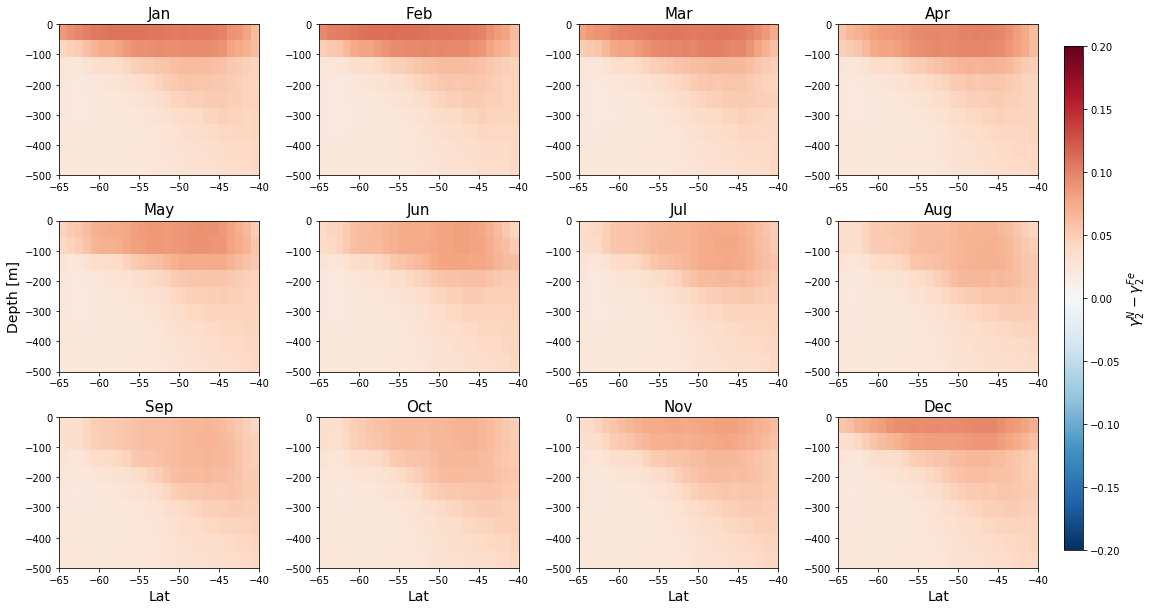

In [84]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18,10))
fig.subplots_adjust(right=0.88, hspace = 0.3, wspace = 0.3)
# fig.set_tight_layout(True)
im = axes[0,0].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN2-gammaFe2)[0],
                         vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[0,1].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN2-gammaFe2)[1],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[0,2].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN2-gammaFe2)[2],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[0,3].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN2-gammaFe2)[3],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)

axes[1,0].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN2-gammaFe2)[4],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[1,1].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN2-gammaFe2)[5],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[1,2].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN2-gammaFe2)[6],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[1,3].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN2-gammaFe2)[7],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)

axes[2,0].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN2-gammaFe2)[8],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[2,1].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN2-gammaFe2)[9],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[2,2].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN2-gammaFe2)[10],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
axes[2,3].pcolormesh(np.linspace(-65,-40,ny), -np.linspace(0,5e2,nz), (gammaN2-gammaFe2)[11],
                    vmax=.2, vmin=-.2, cmap='RdBu_r', rasterized=True)
# cbar2 = fig.colorbar(im2, ax=ax2)
# fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r"$\gamma^{N}_2-\gamma^{Fe}_2$", fontsize=14)
axes[0,0].set_title(r"Jan", fontsize=15)
axes[0,1].set_title(r"Feb", fontsize=15)
axes[0,2].set_title(r"Mar", fontsize=15)
axes[0,3].set_title(r"Apr", fontsize=15)
axes[1,0].set_title(r"May", fontsize=15)
axes[1,1].set_title(r"Jun", fontsize=15)
axes[1,2].set_title(r"Jul", fontsize=15)
axes[1,3].set_title(r"Aug", fontsize=15)
axes[2,0].set_title(r"Sep", fontsize=15)
axes[2,1].set_title(r"Oct", fontsize=15)
axes[2,2].set_title(r"Nov", fontsize=15)
axes[2,3].set_title(r"Dec", fontsize=15)
axes[1,0].set_ylabel(r"Depth [m]", fontsize=14)
axes[2,0].set_xlabel(r"Lat", fontsize=14)
axes[2,1].set_xlabel(r"Lat", fontsize=14)
axes[2,2].set_xlabel(r"Lat", fontsize=14)
axes[2,3].set_xlabel(r"Lat", fontsize=14)
plt.savefig(op.join(woadir, 'ratio-of-gamma2NandFe_WOA-SOSE.pdf'))

In [9]:
N = woa_mon.n_mn.sel(lat=slice(-50.,-40.),lon=slice(50,150)).shape
for j in range(N[-2]):
    for i in range(N[-1]):
        k = 0
        while k < 33:
            if np.isnan(woa_mon.n_mn.sel(lat=slice(-50.,-40.),lon=slice(50,150))[5,k,j,i]):
                woa_mon.n_mn.sel(lat=slice(-50.,-40.),
                                 lon=slice(50,150))[5,k:,j,i] = woa_clim.n_an.sel(lat=slice(-50.,-40.),
                                                                                  lon=slice(50,150))[k:,j,i]
                break
            k += 1

NameError: name 'woa_mon' is not defined

In [10]:
func = pchip(phos_mon.depth, phos_mon[0].sel(lat=-50.,method='nearest').sel(lon=slice(50,150)).mean(['lon']), axis=0)
phos_jan = func(np.abs(Z))
func = pchip(nitr_mon.depth, nitr_mon[0].sel(lat=-50.,method='nearest').sel(lon=slice(50,150)).mean(['lon']), axis=0)
nitr_jan = func(np.abs(Z))
func = pchip(sili_mon.depth, sili_mon[0].sel(lat=-50.,method='nearest').sel(lon=slice(50,150)).mean(['lon']), axis=0)
sili_jan = func(np.abs(Z))

In [26]:
nlat = -45
func = pchip(phos_mon.depth, phos_mon.sel(lat=nlat,method='nearest').sel(lon=slice(50,150)).mean(['lon']), axis=1)
phos_mon = func(np.abs(Z))
func = pchip(nitr_mon.depth, nitr_mon.sel(lat=nlat,method='nearest').sel(lon=slice(50,150)).mean(['lon']), axis=1)
nitr_mon = func(np.abs(Z))
func = pchip(sili_mon.depth, sili_mon.sel(lat=nlat,method='nearest').sel(lon=slice(50,150)).mean(['lon']), axis=1)
sili_mon = func(np.abs(Z))

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:121: RuntimeWarning: invalid value encountered in greater
  mask2 = (np.sign(m0) != np.sign(m1)) & (np.abs(d) > 3.*np.abs(m0))
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:121: RuntimeWarning: invalid value encountered in greater
  mask2 = (np.sign(m0) != np.sign(m1)) & (np.abs(d) > 3.*np.abs(m0))
/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:121: RuntimeWarning: invalid value encountered in greater
  mask2 = (np.sign(m0) != np.sign(m1)) & (np.abs(d) > 3.*np.abs(m0))


In [29]:
nitr_mon.shape

(12, 40)

Text(0.5,1,'NO$_3$')

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


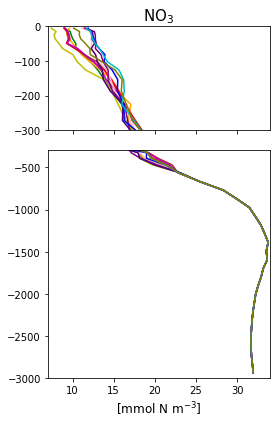

In [27]:
nz = 13
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
colors = ['g','y','orange','brown','r','m','pink','purple','indigo','b','c','olive']

fig = plt.figure(figsize=(4,6))
fig.set_tight_layout(True)
gs = GS(3, 1)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1:,0])
for i in range(12):
    ax1.plot(nitr_mon.T[:,i], Z[:], label=months[i], color=colors[i])
    ax2.plot(nitr_mon.T[:,i], Z[:], label=months[i], color=colors[i])
# ax1.set_xticks(np.arange(.5,12.5))
ax1.set_xticklabels([])
# ax2.set_xticks(np.arange(.5,12.5))
# ax2.set_xticklabels(months)
# ax2.set_xlabel(r"Month", fontsize=14)
ax1.set_xlim([7,34])
ax2.set_xlim([7,34])
ax1.set_ylim([Z[nz-1],0])
ax2.set_ylim([-3000,Z[nz]])
ax1.set_ylim([-300,0])
ax2.set_ylim([-3000,-300])
ax2.set_xlabel(r"[mmol N m$^{-3}$]", fontsize=12)
ax1.set_title(r"NO$_3$", fontsize=15)
# ax2.legend(loc='lower left')
# fig.subplots_adjust(right=0.75)
# fig.subplots_adjust(left=0.15)
# cbar_ax = fig.add_axes([0.8, 0.15, 0.03, 0.7])
# cbar = fig.colorbar(im, cax=cbar_ax)
# cbar.set_label(r"[mmol N m$^{-3}$]", fontsize=12)
# plt.savefig(op.join(woadir,'NO3_NorthRelax_76layers.pdf'))

In [114]:
32.63+219.98

252.60999999999999

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


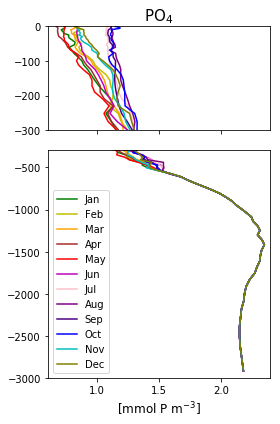

In [26]:
fig = plt.figure(figsize=(4,6))
fig.set_tight_layout(True)
gs = GS(3, 1)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1:,0])
for i in range(12):
    ax1.plot(phos_mon.T[:,i], Z[:], label=months[i], color=colors[i])
    ax2.plot(phos_mon.T[:,i], Z[:], label=months[i], color=colors[i])
# ax1.set_xticks(np.arange(.5,12.5))
ax1.set_xticklabels([])
# ax2.set_xticks(np.arange(.5,12.5))
# ax2.set_xticklabels(months)
# ax2.set_xlabel(r"Month", fontsize=14)
ax1.set_xlim([.6,2.4])
ax2.set_xlim([.6,2.4])
ax1.set_ylim([-300,0])
ax2.set_ylim([-3000,-300])
ax2.set_xlabel(r"[mmol P m$^{-3}$]", fontsize=12)
ax1.set_title(r"PO$_4$", fontsize=15)
ax2.legend(loc='lower left')
# fig.subplots_adjust(right=0.75)
# fig.subplots_adjust(left=0.15)
# cbar_ax = fig.add_axes([0.8, 0.15, 0.03, 0.7])
# cbar = fig.colorbar(im, cax=cbar_ax)
# cbar.set_label(r"[mmol N m$^{-3}$]", fontsize=12)
plt.savefig(op.join(woadir,'PO4_NorthRelax_76layers.pdf'))

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


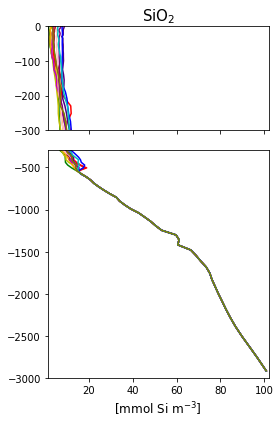

In [30]:
fig = plt.figure(figsize=(4,6))
fig.set_tight_layout(True)
gs = GS(3, 1)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1:,0])
for i in range(12):
    ax1.plot(sili_mon.T[:,i], Z[:], label=months[i], color=colors[i])
    ax2.plot(sili_mon.T[:,i], Z[:], label=months[i], color=colors[i])
# ax1.set_xticks(np.arange(.5,12.5))
ax1.set_xticklabels([])
# ax2.set_xticks(np.arange(.5,12.5))
# ax2.set_xticklabels(months)
# ax2.set_xlabel(r"Month", fontsize=14)
ax1.set_xlim([1.2,1.02e2])
ax2.set_xlim([1.2,1.02e2])
ax1.set_ylim([-300,0])
ax2.set_ylim([-3000,-300])
ax2.set_xlabel(r"[mmol Si m$^{-3}$]", fontsize=12)
ax1.set_title(r"SiO$_2$", fontsize=15)
# ax2.legend(loc='lower left')
# fig.subplots_adjust(right=0.75)
# fig.subplots_adjust(left=0.15)
# cbar_ax = fig.add_axes([0.8, 0.15, 0.03, 0.7])
# cbar = fig.colorbar(im, cax=cbar_ax)
# cbar.set_label(r"[mmol N m$^{-3}$]", fontsize=12)
plt.savefig(op.join(woadir,'SiO2_NorthRelax_76layers.pdf'))

In [35]:
dsave = xr.DataArray(phos_mon, dims=['month','Z'],
                    coords={'month':range(1,13),'Z':Z}).to_dataset('Phos')
dsave['Nitr'] = xr.DataArray(nitr_mon, dims=['month','Z'],
                            coords={'month':range(1,13),'Z':Z})
dsave['Sili'] = xr.DataArray(sili_mon, dims=['month','Z'],
                            coords={'month':range(1,13),'Z':Z})
# dsave.to_netcdf(op.join(woadir,'WOA13_40layers_PNI.nc'))
# dsave

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
  


In [31]:
ds = xr.open_dataset(op.join(sosedir, 'bsose_i105_2008to2012_monthly_Fe.nc'))
fe = ds.Fe
print(ds.Fe.attrs)

month = np.tile(range(12),5)
fe.coords['month'] = ('iTIME',month)

with ProgressBar():
    fe = xr.DataArray(fe.groupby('month').mean('iTIME').data, dims=['month','z','lat','lon'],
                     coords={'month':range(1,13),'z':-ds.depth.data,
                            'lat':ds.lat.data,'lon':ds.lon.data}
                     ).compute()
    
fe

OrderedDict([('dimension', 'mol Fe/m3')])


<xarray.DataArray (month: 12, z: 52, lat: 294, lon: 1080)>
array([[[[         nan, ...,          nan],
         ...,
         [1.174732e-07, ..., 1.173725e-07]],

        ...,

        [[         nan, ...,          nan],
         ...,
         [         nan, ...,          nan]]],


       ...,


       [[[         nan, ...,          nan],
         ...,
         [1.123827e-07, ..., 1.128380e-07]],

        ...,

        [[         nan, ...,          nan],
         ...,
         [         nan, ...,          nan]]]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * z        (z) float64 -2.1 -6.7 -12.15 -18.55 -26.25 -35.25 -45.0 -55.0 ...
  * lat      (lat) float64 -77.97 -77.9 -77.83 -77.75 -77.68 -77.61 -77.54 ...
  * lon      (lon) float64 0.1667 0.5 0.8333 1.167 1.5 1.833 2.167 2.5 2.833 ...

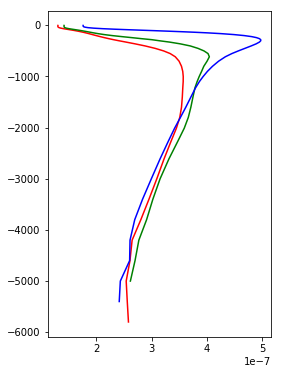

In [14]:
fig, ax = plt.subplots(figsize=(4,6))
ax.plot(fe.sel(lat=-45,method='nearest').sel(lon=slice(50,150)).mean(['month','lon']), fe.z, color='r')
ax.plot(fe.sel(lat=-50,method='nearest').sel(lon=slice(50,150)).mean(['month','lon']), fe.z, color='g')
ax.plot(fe.sel(lat=-60,method='nearest').sel(lon=slice(50,150)).mean(['month','lon']), fe.z, color='b')

/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


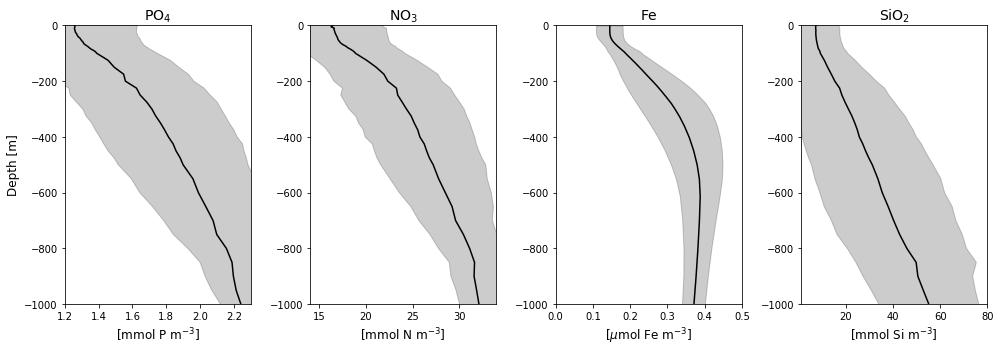

In [165]:
# po4_mid = po4[-60:].sel(YC=slice(6e5,14e5))
# no3_mid = no3[-60:].sel(YC=slice(6e5,14e5))
# fe_mid = fe[-60:].sel(YC=slice(6e5,14e5))*1e3
# io2_mid = io2[-60:].sel(YC=slice(6e5,14e5))

fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(14,5))
fig.set_tight_layout(True)

ax1.plot(phos_mon.sel(lat=-50.,method='nearest').mean(['time','lon']), -phos_mon.depth, 'k')
ax1.fill_betweenx(-phos_mon.depth, 
                 phos_mon.sel(lat=-50.,method='nearest').mean(['time','lon'])
                  - phos_mon.sel(lat=slice(-55.,-45.)).std(['time','lat','lon']),
                 phos_mon.sel(lat=-50.,method='nearest').mean(['time','lon'])
                  + phos_mon.sel(lat=slice(-55.,-45.)).std(['time','lat','lon']),
                 color='k', alpha=0.2)
ax2.plot(nitr_mon.sel(lat=-50.,method='nearest').mean(['time','lon']), -nitr_mon.depth, 'k')
ax2.fill_betweenx(-nitr_mon.depth, 
                 nitr_mon.sel(lat=-50.,method='nearest').mean(['time','lon'])
                  - nitr_mon.sel(lat=slice(-55.,-45.)).std(['time','lat','lon']),
                 nitr_mon.sel(lat=-50.,method='nearest').mean(['time','lon'])
                  + nitr_mon.sel(lat=slice(-55.,-45.)).std(['time','lat','lon']),
                 color='k', alpha=0.2)
ax3.plot(fe.sel(lat=-50.,method='nearest').mean(['month','lon'])*1e6, fe.z, 'k')
ax3.fill_betweenx(fe.z, 
                 (fe.sel(lat=-50.,method='nearest').mean(['month','lon'])
                  - fe.sel(lat=slice(-55.,-45.)).std(['month','lat','lon']))*1e6,
                 (fe.sel(lat=-50.,method='nearest').mean(['month','lon'])
                  + fe.sel(lat=slice(-55.,-45.)).std(['month','lat','lon']))*1e6,
                 color='k', alpha=0.2)
ax4.plot(sili_mon.sel(lat=-50.,method='nearest').mean(['time','lon']), -sili_mon.depth, 'k')
ax4.fill_betweenx(-sili_mon.depth, 
                 sili_mon.sel(lat=-50.,method='nearest').mean(['time','lon'])
                  - sili_mon.sel(lat=slice(-55.,-45.)).std(['time','lat','lon']),
                 sili_mon.sel(lat=-50.,method='nearest').mean(['time','lon'])
                  + sili_mon.sel(lat=slice(-55.,-45.)).std(['time','lat','lon']),
                 color='k', alpha=0.2)

ax1.set_title(r"PO$_4$", fontsize=14)
ax2.set_title(r"NO$_3$", fontsize=14)
ax3.set_title(r"Fe", fontsize=14)
ax4.set_title(r"SiO$_2$", fontsize=14)
ax1.set_ylabel(r"Depth [m]", fontsize=12)
ax1.set_xlabel(r"[mmol P m$^{-3}$]", fontsize=12)
ax2.set_xlabel(r"[mmol N m$^{-3}$]", fontsize=12)
ax3.set_xlabel(r"[$\mu$mol Fe m$^{-3}$]", fontsize=12)
ax4.set_xlabel(r"[mmol Si m$^{-3}$]", fontsize=12)
ax1.set_xlim([1.2,2.3])
ax2.set_xlim([14,34])
ax3.set_xlim([0.,0.5])
ax4.set_xlim([1e0,8e1])
ax1.set_ylim([-1e3,0.])
ax2.set_ylim([-1e3,0.])
ax3.set_ylim([-1e3,0.])
ax4.set_ylim([-1e3,0.])

plt.savefig(op.join(woadir,'Vertical-profile_PNFeSi_WOA-SOSE.pdf'))

In [131]:
# func = pchip(np.abs(fe.z), fe[0].sel(lat=-50.,method='nearest').sel(lon=slice(50,150)).mean(['lon']), axis=0)
# fe_jan = xr.DataArray(1e3*func(np.abs(Z)), dims=['Z'],
#                      coords={'Z':Z})
# fe_jan

<xarray.DataArray (Z: 40)>
array([0.000112, 0.000112, 0.000112, 0.000113, 0.000118, 0.000136, 0.000161,
       0.000183, 0.000199, 0.00021 , 0.000228, 0.00026 , 0.000301, 0.00034 ,
       0.000372, 0.000392, 0.000405, 0.000404, 0.000398, 0.000394, 0.000389,
       0.000386, 0.000382, 0.000379, 0.000377, 0.000375, 0.000373, 0.000371,
       0.000368, 0.000365, 0.00036 , 0.000356, 0.000351, 0.000346, 0.000341,
       0.000336, 0.000331, 0.000327, 0.000322, 0.000318])
Coordinates:
  * Z        (Z) float64 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 ...

In [32]:
nlatfe = -50
func = pchip(np.abs(fe.z), fe.sel(lat=nlatfe,method='nearest').sel(lon=slice(50,150)).mean(['lon']), axis=1)
fe_mon = xr.DataArray(1e3*func(np.abs(Z)), dims=['month','Z'],
                     coords={'month':range(1,13),'Z':Z})
print(nlat,fe_mon)

-45 <xarray.DataArray (month: 12, Z: 40)>
array([[0.000112, 0.000112, 0.000112, ..., 0.000327, 0.000322, 0.000318],
       [0.00011 , 0.000109, 0.000109, ..., 0.000327, 0.000322, 0.000318],
       [0.000112, 0.000112, 0.000112, ..., 0.000327, 0.000322, 0.000318],
       ...,
       [0.000175, 0.000175, 0.000176, ..., 0.000325, 0.000321, 0.000317],
       [0.000151, 0.000151, 0.000151, ..., 0.000325, 0.000321, 0.000317],
       [0.000124, 0.000124, 0.000125, ..., 0.000325, 0.000321, 0.000317]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * Z        (Z) float64 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 ...


/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:121: RuntimeWarning: invalid value encountered in greater
  mask2 = (np.sign(m0) != np.sign(m1)) & (np.abs(d) > 3.*np.abs(m0))


/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


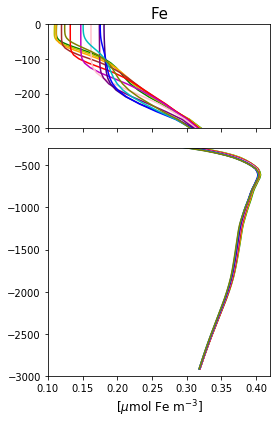

In [34]:
nz = 13
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
colors = ['g','y','orange','brown','r','m','pink','purple','indigo','b','c','olive']
fig = plt.figure(figsize=(4,6))
fig.set_tight_layout(True)
gs = GS(3, 1)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1:,0])
for i in range(12):
    ax1.plot(fe_mon.T[:,i]*1e3, Z[:], label=months[i], color=colors[i])
    ax2.plot(fe_mon.T[:,i]*1e3, Z[:], label=months[i], color=colors[i])
# ax1.set_xticks(np.arange(.5,12.5))
ax1.set_xticklabels([])
# ax2.set_xticks(np.arange(.5,12.5))
# ax2.set_xticklabels(months)
# ax2.set_xlabel(r"Month", fontsize=14)
ax1.set_xlim([0.1,0.42])
ax2.set_xlim([0.1,0.42])
ax1.set_ylim([-300,0])
ax2.set_ylim([-3000,-300])
ax2.set_xlabel(r"[$\mu$mol Fe m$^{-3}$]", fontsize=12)
ax1.set_title(r"Fe", fontsize=15)
# ax2.legend(loc='lower left')
# fig.subplots_adjust(right=0.75)
# fig.subplots_adjust(left=0.15)
# cbar_ax = fig.add_axes([0.8, 0.15, 0.03, 0.7])
# cbar = fig.colorbar(im, cax=cbar_ax)
# cbar.set_label(r"[mmol N m$^{-3}$]", fontsize=12)
plt.savefig(op.join(sosedir,'Fe_NorthRelax_76layers.pdf'))

In [33]:
def gen_binary(da, dtype='>f8', nz=15, res=1e0, X=1e6, Y=2e6, ddir=woadir, deg=45, savefile='FeT-seasonal-relax_BSOSE'):
    
    nx = int(X/(res*1e3))
    ny = int(Y/(res*1e3))
    dnew = (da.data[:,:,np.newaxis,np.newaxis]*np.ones((ny,nx)))
    nS = int(1.4e2/res)
    dnew[:,:,:nS] = 0.
    print(dnew.shape)
        
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    fig.set_tight_layout(True)
    im1 = ax1.pcolormesh(range(1,13),da.Z[:nz],dnew[:,:,-1,0].T[:nz])
    im2 = ax2.pcolormesh(np.arange(0,X*1e-3,res),np.arange(0,Y*1e-3,res),dnew[0,0])
    fig.colorbar(im2, ax=ax2)
    fig.colorbar(im1, ax=ax1)
    
    dnew.astype(dtype).tofile(op.join(ddir, savefile + '%02dS-%03dkm.bin' % (int(deg),int(res))))

(12, 40, 20, 10)
(12, 40, 20, 10)
(12, 40, 20, 10)
(12, 40, 20, 10)


/home/takaya/miniconda3/envs/uptodate/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


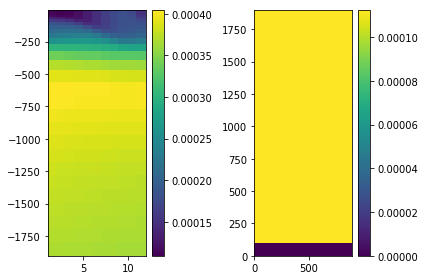

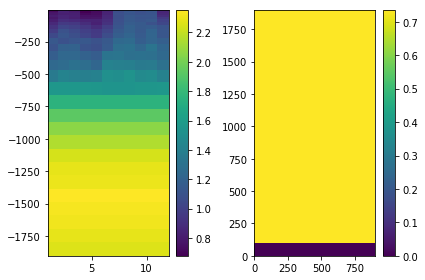

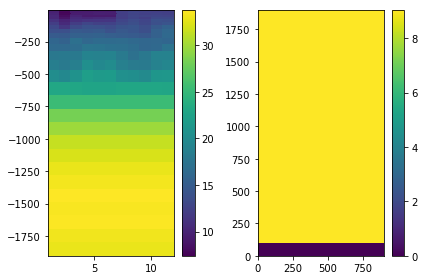

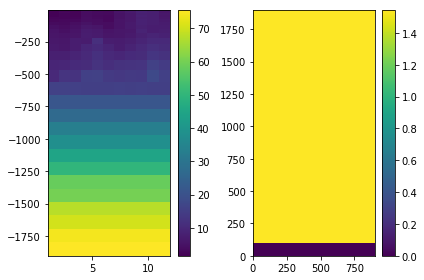

In [36]:
gen_binary(fe_mon, nz=30, res=100e0, deg=50, ddir=sosedir)
gen_binary(dsave.Phos, nz=30, res=100e0, ddir=woadir, savefile='PO4-seasonal-relax_WOA13')
gen_binary(dsave.Nitr, nz=30, res=100e0, ddir=woadir, savefile='NO3-seasonal-relax_WOA13')
gen_binary(dsave.Sili, nz=30, res=100e0, ddir=woadir, savefile='iO2-seasonal-relax_WOA13')

In [35]:
dtype = '>f4'
fe_jan.data.astype(dtype).tofile(op.join(sosedir, 'FeT-JAN-50S_BSOSE.bin'))
phos_jan.astype(dtype).tofile(op.join(woadir, 'PO4-JAN-50S_WOA.bin'))
nitr_jan.astype(dtype).tofile(op.join(woadir, 'NO3-JAN-50S_WOA.bin'))
sili_jan.astype(dtype).tofile(op.join(woadir, 'iO2-JAN-50S_WOA.bin'))